In [1]:
from dotenv import load_dotenv
import pandas as pd
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [2]:
import tensorflow as tf
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [])

In [3]:
def df_to_X_y(df: pd.DataFrame):
    df_as_np = df.to_numpy()
    X = df_as_np[:, 4:]
    y = df_as_np[:, :1]
    return X, y

def date_range(start: datetime.date, end: datetime.date, step: datetime.timedelta):
    while start < end:
        yield start
        start += step

In [4]:
df_train = pd.concat([
    pd.read_csv(f'../datasets/{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 10, 7), 
        datetime.date(2020, 1, 6),
        datetime.timedelta(weeks=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 1, 6), 
        datetime.date(2020, 2, 3),
        datetime.timedelta(weeks=1),
    )
])
df_test = pd.concat([
    pd.read_csv(f'../datasets/{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 3), 
        datetime.date(2020, 2, 25),
        datetime.timedelta(weeks=1),
    )
])

X_train, y_train = df_to_X_y(df_train)
X_val, y_val = df_to_X_y(df_val)
X_test, y_test = df_to_X_y(df_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((448543, 38),
 (448543, 1),
 (148699, 38),
 (148699, 1),
 (154929, 38),
 (154929, 1))

In [5]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam


model = Sequential()
model.add(InputLayer((38, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp = ModelCheckpoint('../model/model1.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
14017/14017 [==============================] - 200s 14ms/step - loss: 0.4230 - root_mean_squared_error: 0.6504 - val_loss: 0.8340 - val_root_mean_squared_error: 0.9132
Epoch 2/10
14017/14017 [==============================] - 208s 15ms/step - loss: 0.3964 - root_mean_squared_error: 0.6296 - val_loss: 0.8102 - val_root_mean_squared_error: 0.9001
Epoch 3/10
14017/14017 [==============================] - 212s 15ms/step - loss: 0.3653 - root_mean_squared_error: 0.6044 - val_loss: 0.8006 - val_root_mean_squared_error: 0.8948
Epoch 4/10
14017/14017 [==============================] - 220s 16ms/step - loss: 0.3533 - root_mean_squared_error: 0.5944 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9084
Epoch 5/10
14017/14017 [==============================] - 230s 16ms/step - loss: 0.3369 - root_mean_squared_error: 0.5804 - val_loss: 0.7620 - val_root_mean_squared_error: 0.8729
Epoch 6/10
14017/14017 [==============================] - 233s 17ms/step - loss: 0.3348 - root_mean_squar

KeyboardInterrupt: 

In [24]:
from sqlalchemy import orm
import sqlalchemy as sa
from schemas.parameter import Parameter


conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

parameters = dict[str, float]()
with orm.Session(engine) as session, session.begin():
    for row in session.scalars(sa.select(Parameter)).all():
        parameters[row.name] = row.value

p = model.predict(X_test)
df = pd.DataFrame({ 
    'predict_view': p[:, 0] * parameters['std_view'] + parameters['mean_view'],
    'view': y_test[:, 0] * parameters['std_view'] + parameters['mean_view'],
    # 'predict_cart': p[:, 1] * parameters['std_cart'] + parameters['mean_cart'],
    # 'cart': y_test[:, 1] * parameters['std_cart'] + parameters['mean_cart'],
    # 'predict_remove_from_cart': p[:, 2] * parameters['std_remove_from_cart'] + parameters['mean_remove_from_cart'],
    # 'remove_from_cart': y_test[:, 2] * parameters['std_remove_from_cart'] + parameters['mean_remove_from_cart'],
    # 'predict_purchase': p[:, 3] * parameters['std_purchase'] + parameters['mean_purchase'],
    # 'purchase': y_test[:, 3] * parameters['std_purchase'] + parameters['mean_purchase'],
})
df.to_csv('test.csv')

4842/4842 [==============================] - 26s 5ms/step


0          0.259054
1          3.098728
2          3.010428
3          0.823194
4          0.897185
            ...    
154924     1.356668
154925    17.575794
154926     9.104113
154927     0.823423
154928    41.264946
Length: 154929, dtype: float64


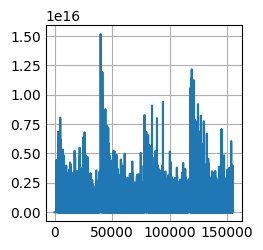

In [29]:
import matplotlib.pyplot as plt

result = pd.read_csv('test.csv')

# Example data
actual_values = result['view']
predicted_values = result['predict_view']

acc = predicted_values / actual_values
print(acc)


plt.plot(acc)

# Show plot
plt.grid(True)
plt.show()

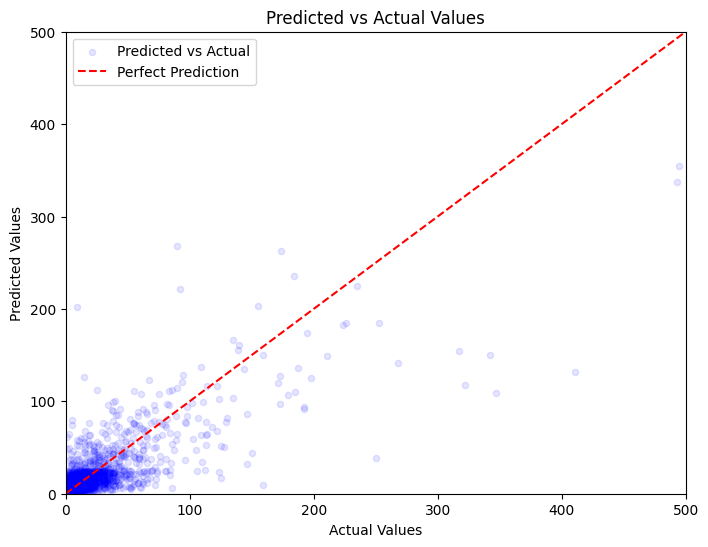

In [18]:
import matplotlib.pyplot as plt

result = pd.read_csv('test.csv')

# Example data
actual_values = result['view']
predicted_values = result['predict_view']

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Predicted vs Actual', s=20, alpha=0.1)

# Plot y = x line for reference
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

plt.xlim(0, 500)
plt.ylim(0, 500)

# Add legend
plt.legend()

# Show plot
plt.show()